In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.samplers import TPESampler

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e6/sample_submission.csv
/kaggle/input/playground-series-s3e6/train.csv
/kaggle/input/playground-series-s3e6/test.csv
/kaggle/input/paris-housing-price-prediction/ParisHousing.csv


# 1. Setup

In [2]:
feature_engineering = True # Whether you wish to perform some feature engineering
TUNE = False # Whether you wish to tune the models (which takes a few hours)
RANDOM = 42 # Random state
BASIC = False # Whether you wish to use the optimized hyperparameters or just the basic models
VR = True # Whether to submit the voting regressor predictions 
OUTLIERS_REMOVE = True # Whether to remove the outliers or not
REMOVE_FEATURES = True # Whether to remove certain features from the features list

# 2. Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
original = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e6/sample_submission.csv')

In [4]:
train.drop('id', axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [5]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

##### There seems to be no missing values so let's concatenate them together

In [6]:
total_train = pd.concat([train, original])
total_train.drop_duplicates(inplace=True)

In [7]:
total_train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


##### Defining feature and target variables

In [8]:
features = list(total_train.columns[:-1])
target = 'price'

## 2.1 Visualizing

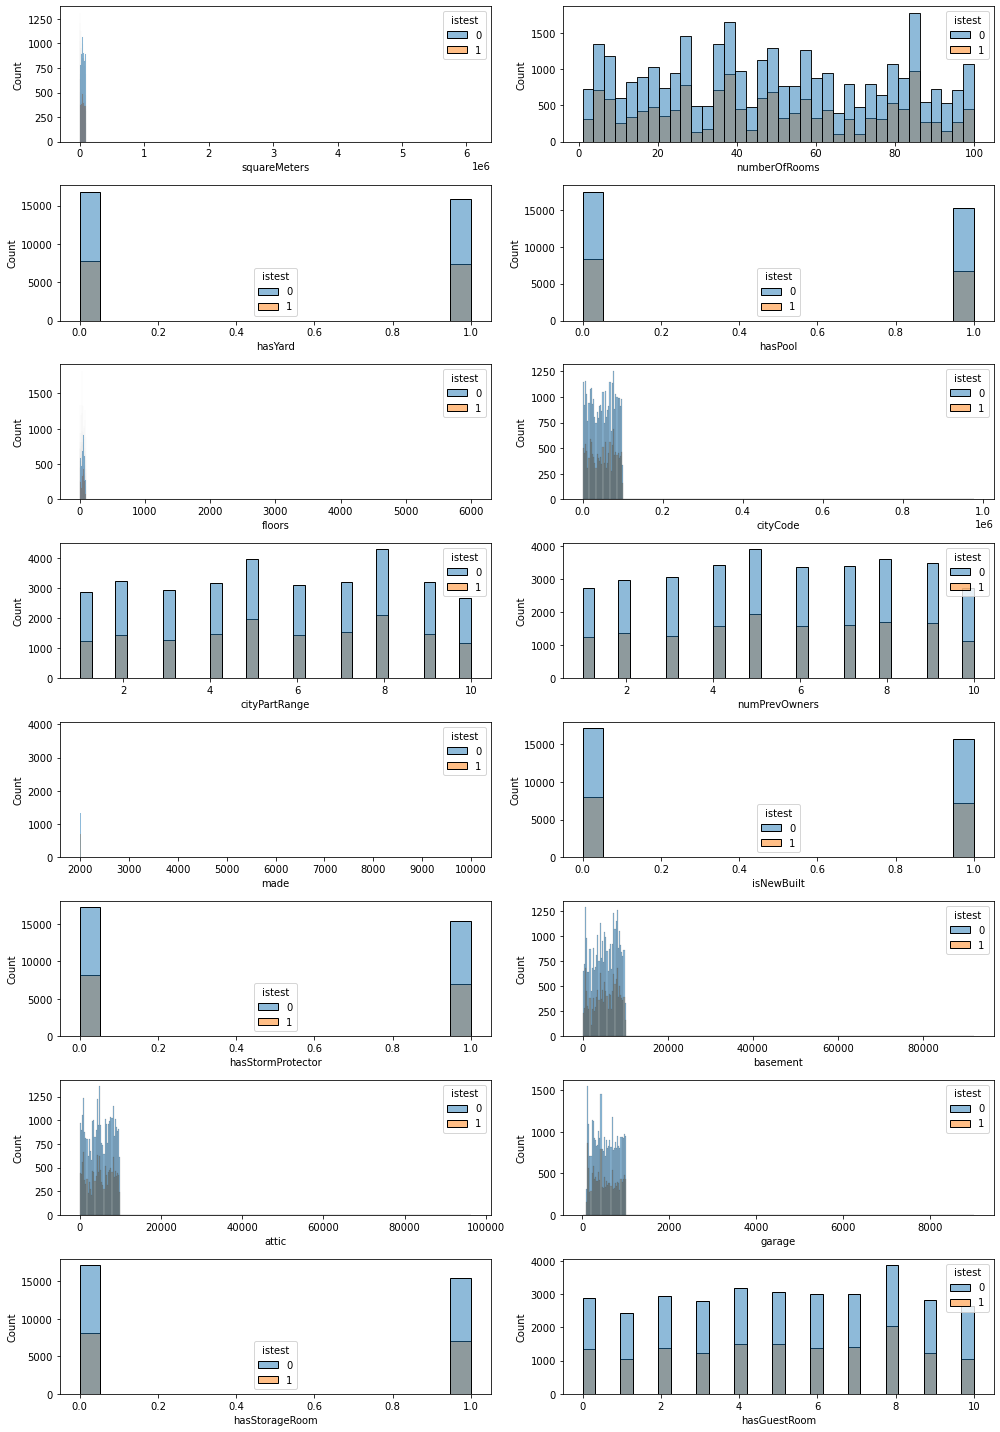

In [9]:
fig, axs = plt.subplots(8, 2, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(8):
    for j in range(2):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

In [10]:
total_train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,istest
count,3.272900e+04,32729.000000,32729.00000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,32729.000000,3.272900e+04,32729.0
mean,4.759037e+04,48.887959,0.48593,0.466223,48.212839,50078.726053,5.562193,5.590577,2007.235968,0.477497,0.472211,5207.240735,5055.821901,537.383360,0.474319,5.104678,4.744220e+06,0.0
std,4.425313e+04,28.424804,0.49981,0.498865,42.919752,29704.827499,2.780882,2.758045,99.165310,0.499501,0.499235,2998.176980,3036.804048,271.194779,0.499348,3.093623,2.915318e+06,0.0
min,8.900000e+01,1.000000,0.00000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04,0.0
25%,2.158100e+04,25.000000,0.00000,0.000000,25.000000,23446.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2792.000000,2561.000000,307.000000,0.000000,2.000000,2.159844e+06,0.0
50%,4.613200e+04,48.000000,0.00000,0.000000,46.000000,50452.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5306.000000,4988.000000,530.000000,0.000000,5.000000,4.621606e+06,0.0
75%,7.254500e+04,75.000000,1.00000,1.000000,72.000000,76229.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7722.000000,7623.000000,770.000000,1.000000,8.000000,7.259025e+06,0.0
max,6.071330e+06,100.000000,1.00000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000677e+07,0.0


##### As we can see from the plots above, the features we have seem to follow no particular distribution and some of them have very extreme values.
##### However, a tree based approach for our predictions won't be negatively affected by this fact.
##### However, we can also try removing these outliers

## 2.2 Boxplots

##### Let's use a boxplot to visualize the outliers better

### 2.2.1 Train

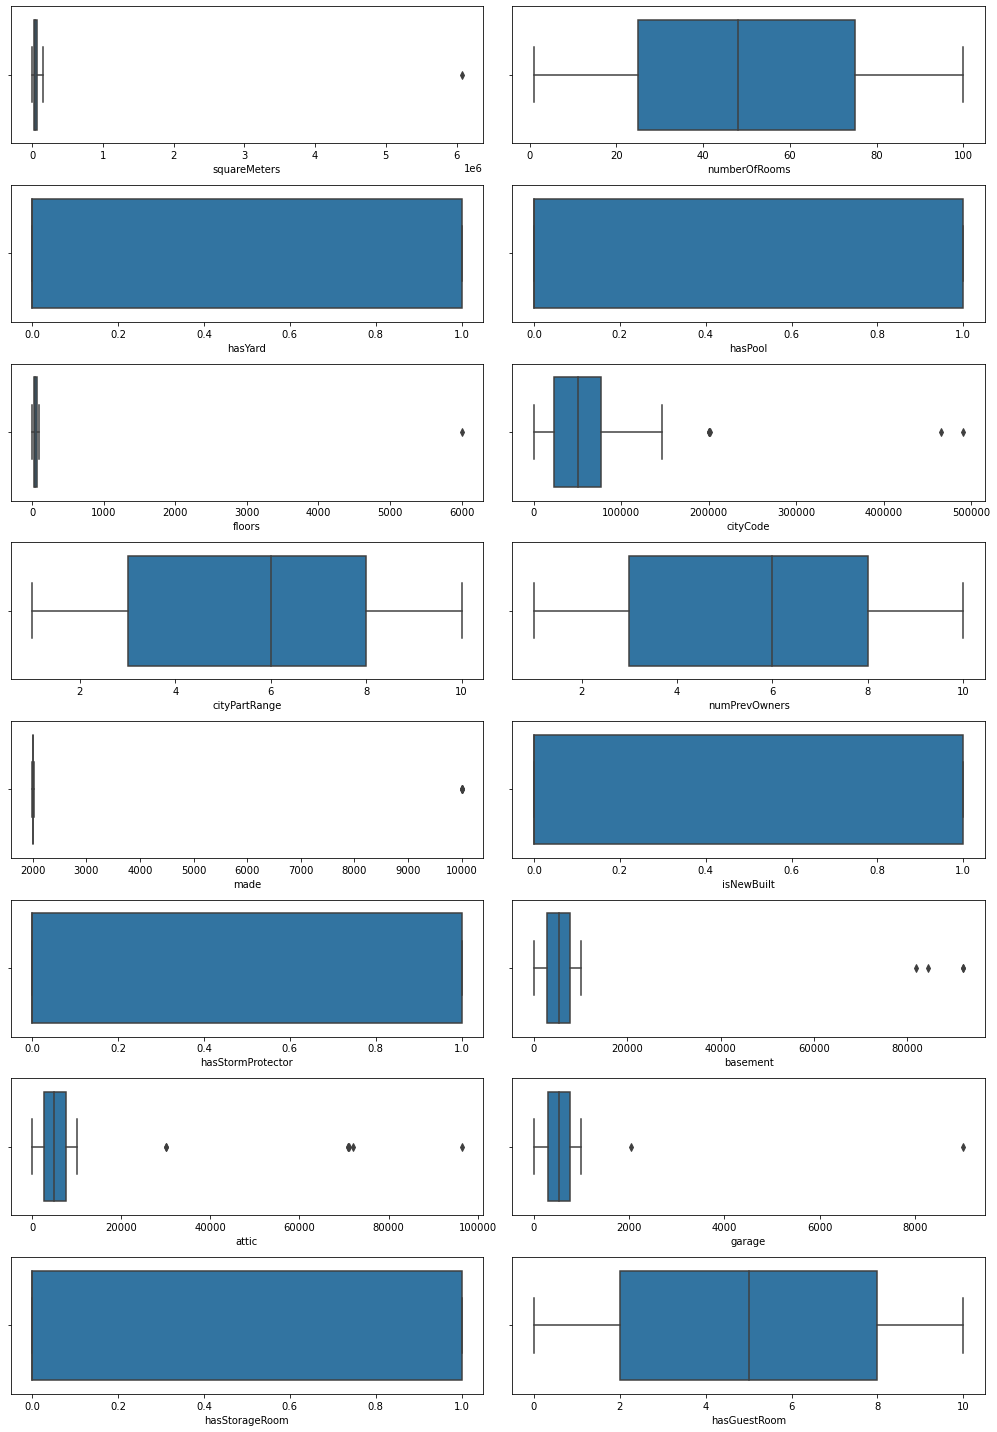

In [11]:
fig, axs = plt.subplots(8, 2, figsize=(14,20))
for i in range(8):
    for j in range(2):
        sns.boxplot(x = total_train[features][features[i*2+j]],ax=axs[i][j])
plt.tight_layout()
plt.show()

### 2.2.2 Test

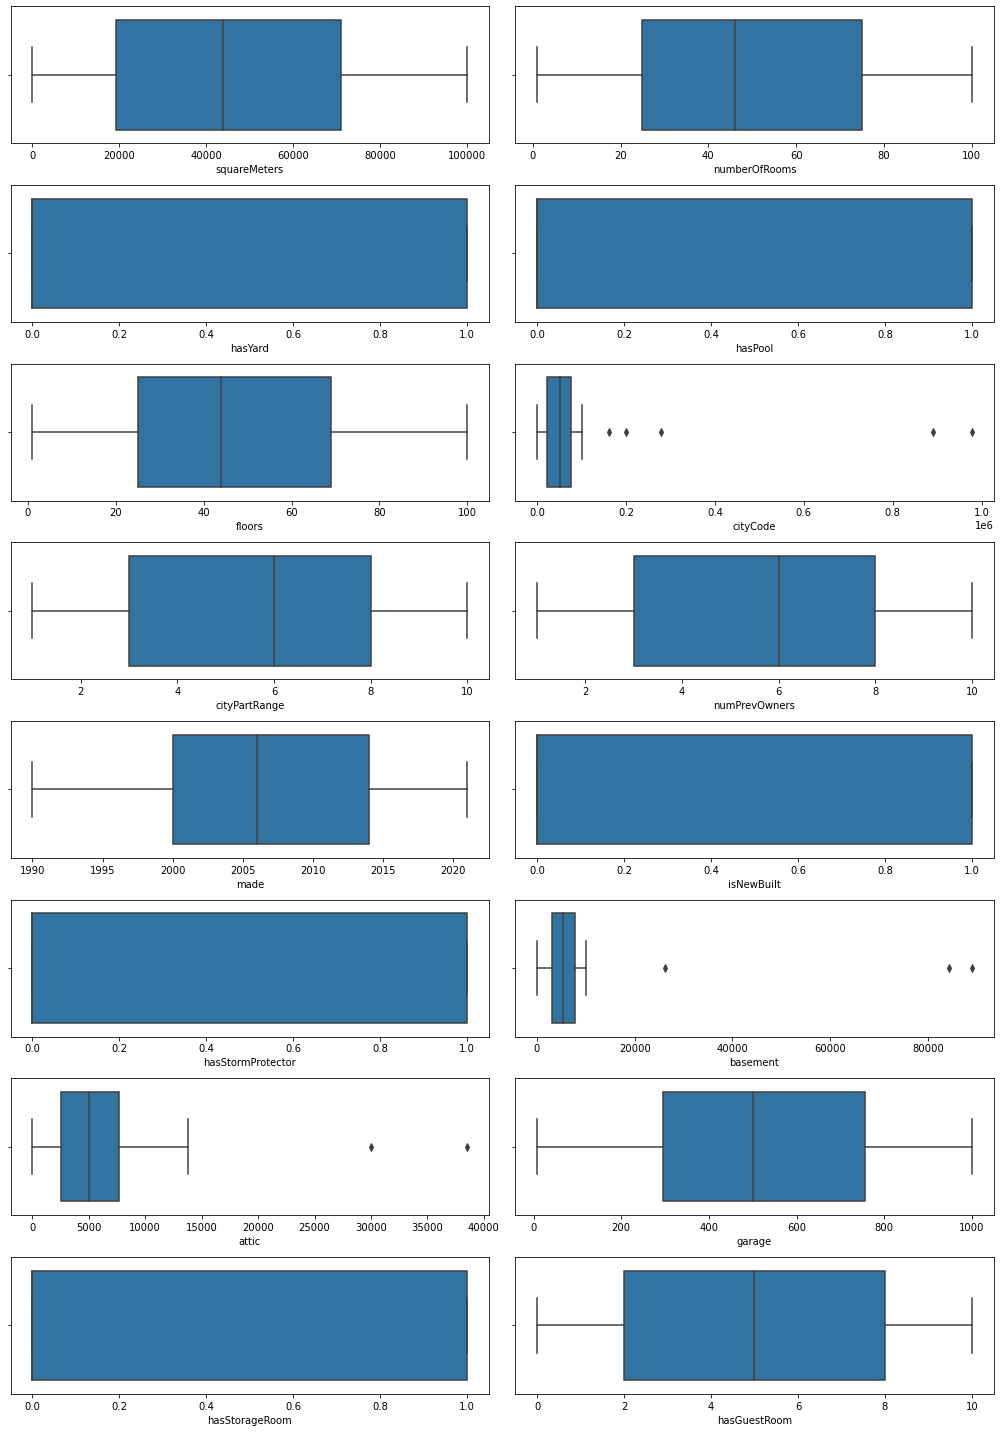

In [12]:
fig, axs = plt.subplots(8, 2, figsize=(14,20))
for i in range(8):
    for j in range(2):
        sns.boxplot(x = test[features][features[i*2+j]],ax=axs[i][j])
plt.tight_layout()
plt.show()

##### So the training dataset does seem to have more extreme outliers than the test dataset which is a relief.
##### So we can proceed on to remove the obvious outliers from the training dataset.

## 2.3 Removing Outliers

In [13]:
if OUTLIERS_REMOVE:
    total_train = total_train[total_train['squareMeters'] < 100000]
    total_train = total_train[total_train['floors'] < 1000]
    total_train = total_train[total_train['made'] < 2023]
    total_train = total_train[total_train['garage'] < 1100]

##### Let's check the distributions after outlier removals

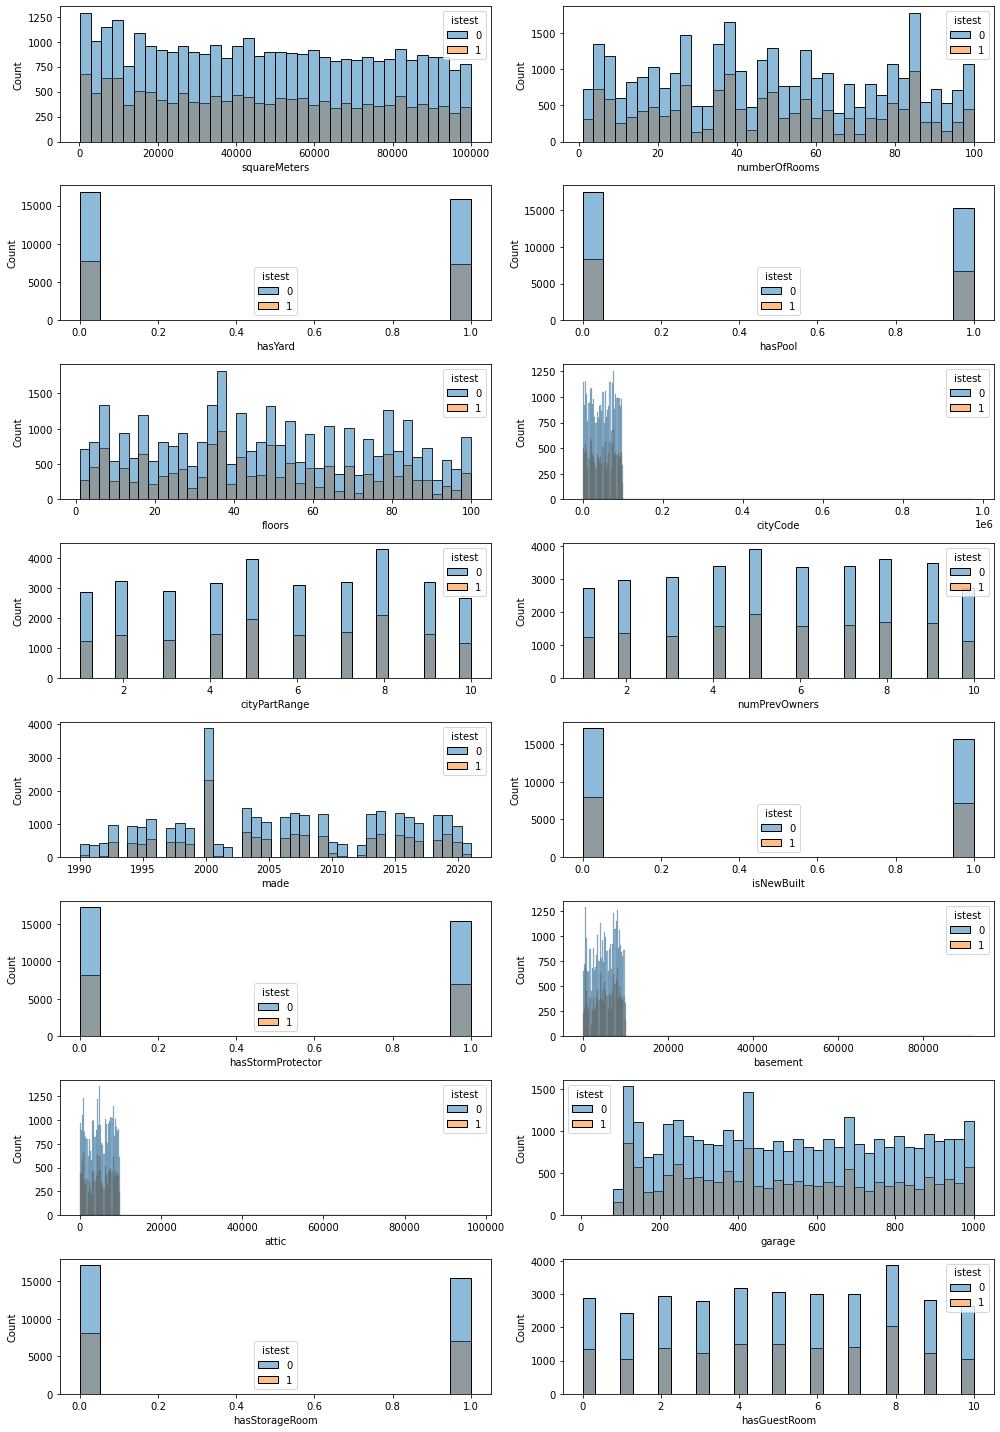

In [14]:
fig, axs = plt.subplots(8, 2, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(8):
    for j in range(2):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

##### Now this surely looks much better

## 2.4 Correlations

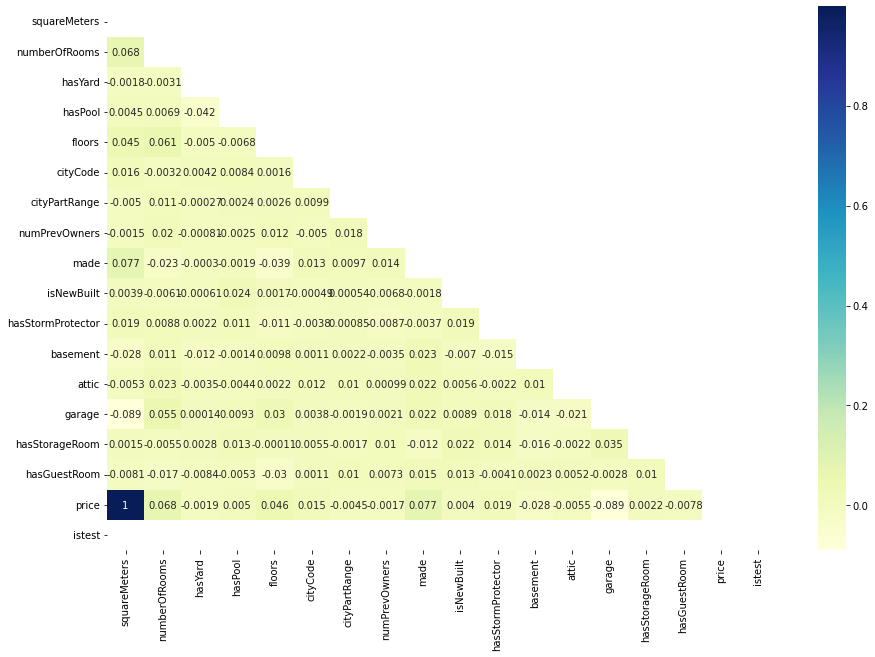

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
corr = total_train.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask = matrix,cmap="YlGnBu")
plt.show()

##### This plot makes it obvious now that only the squareMeters feature seems to have substantial correlation w.r.t. the price feature.
##### Other features are minutely correlated with our target variable overall.

## 2.5 Feature Engineering

##### Time for some creative feature engineering on my part.

In [16]:
if feature_engineering:
    total_train['istest'] = 0
    test['istest'] = 1
    raw = pd.concat([total_train, test])

    raw['rooms_floor'] = raw['numberOfRooms'] * raw['floors']
    
    total_train = raw[raw['istest'] == 0]
    test = raw[raw['istest'] == 1]
    
    features.extend(['rooms_floor'])

if REMOVE_FEATURES: 
    for i in ['cityPartRange', 'hasPool', 'isNewBuilt', 'hasYard', 'hasStorageRoom', 'hasStormProtector', 'made', 'attic', 'numPrevOwners']:
        features.remove(i)

## 2.6 Scaling

##### Let's also create a scaled dataset to test out our models on

In [17]:
def scale_features(train, test, features):
    scalar = StandardScaler()
    train_copy = train.copy()
    test_copy = test.copy()
    train_copy[features] = scalar.fit_transform(train_copy[features])
    test_copy[features] = scalar.transform(test_copy[features])
    return train_copy, test_copy

total_train_scaled, test_scaled = scale_features(total_train, test, features)

# 3. Modeling

In [18]:
X = total_train[features]
y = total_train[target]

X_scaled = total_train_scaled[features]
y_scaled = total_train_scaled[target]

## 3.1 XGBoost

In [19]:
if BASIC:
    xgb_params = {
        'random_state': RANDOM,
        'verbosity' : 0,
        'tree_method': 'gpu_hist'
    }

else: 
    xgb_params = {'max_depth': 2, 
                  'learning_rate': 0.059769988100428606, 
                  'n_estimators': 391, 
                  'min_child_weight': 8, 
                  #'gamma': 0.46278554200306, 
                  #'subsample': 0.9759826880277898, 
                  #'colsample_bytree': 0.9277923525825847, 
                  #'reg_alpha': 0.20652358674645502, 
                  #'reg_lambda': 0.6725590604137306,
                  'verbosity' : 0}

xgbr = XGBRegressor(**xgb_params) 

print(np.mean(cross_val_score(xgbr, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

130007.55265419048


## 3.2 CatBoostRegressor

In [20]:
if BASIC:
    catboost_params = {
        'random_state': RANDOM,
        'verbose' : False
    }
else:
    catboost_params = {'iterations': 809, 
                       'learning_rate': 0.042602585051201895, 
                       'depth': 4, 
                       #'l2_leaf_reg': 0.005046406219549162, 
                       #'bootstrap_type': 'Bayesian', 
                       #'random_strength': 21.97158698431444, 
                       #'bagging_temperature': 3.674063631101739, 
                       #'od_type': 'IncToDec', 
                       #'od_wait': 46,
                       'verbose':False}

catboost = CatBoostRegressor(**catboost_params)

print(np.mean(cross_val_score(catboost, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

117412.582121118


## 3.3 LGBMRegressor

In [21]:
if BASIC:
    lgbm_params = {
        'verbose' : -1,
        'device': 'gpu',
        'random_state': RANDOM
    }

else:
    lgbm_params = {'boosting_type': 'gbdt', 
                   'num_leaves': 53, 
                   'learning_rate': 0.11410268498973851, 
                   'n_estimators': 486, 
                   'max_depth': 9, 
                   #'min_child_samples': 68, 
                   #'subsample': 0.2727810369325321, 
                   #'colsample_bytree': 0.9592572123722509, 
                   #'reg_alpha': 0.22539189902577744, 
                   #'reg_lambda': 0.8376573917694309,
                   'verbose':-1}

lgbm = LGBMRegressor(**lgbm_params)

print(np.mean(cross_val_score(lgbm, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

132316.93488002213


## 3.4 AdaBoostRegressor

In [22]:
ada = AdaBoostRegressor()

print(np.mean(cross_val_score(lgbm, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

132316.93488002213


## 3.5 Random Forest

In [23]:
rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)

print(np.mean(cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

136103.15673164892


## 3.6 Linear Regression

In [24]:
lr = LinearRegression()

print(np.mean(cross_val_score(lr, X_scaled, y_scaled, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

138406.93263119637


## 3.7 Ridge Regression

In [25]:
rd = Ridge()

print(np.mean(cross_val_score(rd, X_scaled, y_scaled, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

138421.76555389777


## 3.8 Voting Regressor

In [26]:
vr = VotingRegressor([('xgb', xgbr), ('catboost', catboost), ('lgbm', lgbm)])

print(np.mean(cross_val_score(vr, X, y, cv=5, scoring='neg_root_mean_squared_error'))*(-1))

118263.1270858834


##### Ok so at least the voting regressor, ensembling the three most powerful tree-based method yields us the best score
##### Let's see whether hyperparameter tuning will help us yield better resulst

# 4. Hyperparameter Tuning

### 4.1 XGBoost

In [27]:
def objective(trial):   
    params_optuna = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method":"gpu_hist",
        'random_state': RANDOM,
        }

    xgb_tuned = XGBRegressor(**params_optuna)
    scores = cross_val_score(xgb_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=RANDOM),
                            scoring="neg_root_mean_squared_error"
                            )
    return (scores.mean() * (-1))

if TUNE:
    xgb_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    xgb_tuning.optimize(func=objective, n_trials=100)
    print(xgb_tuning.best_params)

### 4.2 CatBoostRegressor

In [28]:
def objective(trial): 
    
    params_optuna = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate' : trial.suggest_float('learning_rate',0.01, 1),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength': trial.suggest_float('random_strength',10,50),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'verbose':False,
        'task_type' : 'GPU',
        'random_state': RANDOM,
    }

    catboost_tuned = CatBoostRegressor(**params_optuna)
    scores = cross_val_score(catboost_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=RANDOM),
                            scoring="neg_root_mean_squared_error"
                            )
    return (scores.mean() * (-1))

if TUNE:
    catboost_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    catboost_tuning.optimize(func=objective, n_trials=100)
    print(catboost_tuning.best_params)

## 4.3 LGBMRegressor

In [29]:
def objective(trial): 
    
    params_optuna = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 1.0),
        'random_state': RANDOM,
        'device': 'gpu'
    }

    lgbm_tuned = LGBMRegressor(**params_optuna)
    scores = cross_val_score(lgbm_tuned, X, y, 
                            cv=KFold(n_splits=10,
                            shuffle=True,
                            random_state=RANDOM),
                            scoring="neg_root_mean_squared_error"
                            )
    return (scores.mean() * (-1))

if TUNE:
    lgbm_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    lgbm_tuning.optimize(func=objective, n_trials=100)
    print(lgbm_tuning.best_params)

# 5. Result Analysis

In [30]:
xgbr.fit(X,y)
catboost.fit(X,y)
lgbm.fit(X,y)
lr.fit(X_scaled,y_scaled)
rd.fit(X_scaled,y_scaled)

Ridge()

## 5.1 Feature Importance

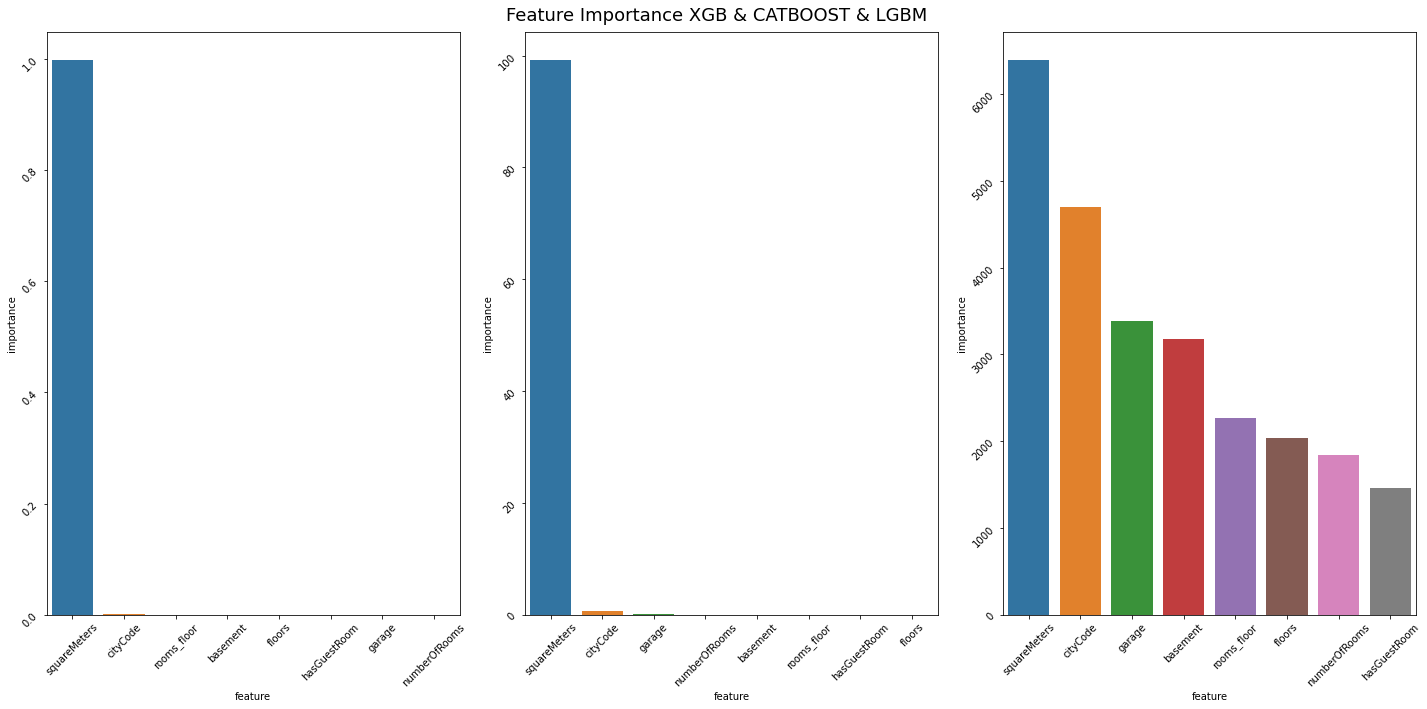

In [31]:
model1, model2, model3 = xgbr, catboost, lgbm

fe =sorted(list(zip(model1.feature_names_in_,model1.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe = pd.DataFrame(fe,columns= ['feature', 'importance'])
fe =sorted(list(zip(model2.feature_names_,model2.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe2 = pd.DataFrame(fe,columns= ['feature', 'importance'])
fe =sorted(list(zip(model3.feature_name_,model3.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe3 = pd.DataFrame(fe,columns= ['feature', 'importance'])

fig, axs = plt.subplots(1, 3, figsize=(20,10))
sns.barplot(data = df_fe, x= 'feature', y= 'importance',ax=axs[0])
axs[0].tick_params(labelrotation=45)
sns.barplot(data = df_fe2, x= 'feature', y= 'importance',ax=axs[1])
axs[1].tick_params(labelrotation=45)
sns.barplot(data = df_fe3, x= 'feature', y= 'importance',ax=axs[2])
axs[2].tick_params(labelrotation=45)

plt.suptitle("Feature Importance XGB & CATBOOST & LGBM",size=18)
plt.tight_layout()
plt.show()

# 6. Submission

In [32]:
test.drop(['istest', 'id', 'price'], axis=1, inplace=True)
# test_scaled.drop(['istest', 'id', 'price'], axis=1, inplace=True)
test = test[features]
test_scaled = test_scaled[features]

vr.fit(X,y)
vr_pred = vr.predict(test)

xgb_pred = xgbr.predict(test)
catboost_pred = catboost.predict(test)
lgbm_pred = lgbm.predict(test)
lr_pred = lr.predict(test_scaled)
rd_pred = rd.predict(test_scaled)
# ensemble_pred = (xgb_pred+catboost_pred+lgbm_pred+lr_pred+rd_pred)/5
if REMOVE_FEATURES:
    ensemble_pred = xgb_pred * 0.6 + catboost_pred * 0.2 + lgbm_pred * 0.2
else:
    ensemble_pred = xgb_pred * 0.2 + catboost_pred * 0.4 + lgbm_pred * 0.2 + lr_pred * 0.1 + rd_pred * 0.1

In [33]:
if vr:
    sample['price'] = vr_pred
else:
    sample['price'] = ensemble_pred
    
sample.to_csv('submission.csv', index=False)
sample.head()

,id,price
0,22730,4.773708e+06
1,22731,6.198208e+06
2,22732,9.042042e+06
3,22733,1.645503e+06
4,22734,6.757399e+06
